(6750281, 6)
         Timestamp     Open     High      Low    Close    Volume
6750280        NaN  57854.0  57864.0  57835.0  57835.0  1.353466
            Timestamp       Open       High        Low      Close    Volume
0        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
1        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
2        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
3        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
4        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
...               ...        ...        ...        ...        ...       ...
6750275  1.737936e+09  102518.00  102559.00  102506.00  102558.00  0.771165
6750276  1.737936e+09  102628.00  102669.00  102608.00  102611.00  0.086742
6750277  1.737936e+09  102659.00  102712.00  102657.00  102712.00  0.488757
6750278  1.737936e+09  102631.00  102631.00  102573.00  102573.00  0.126719
6750279  1.737936e+09

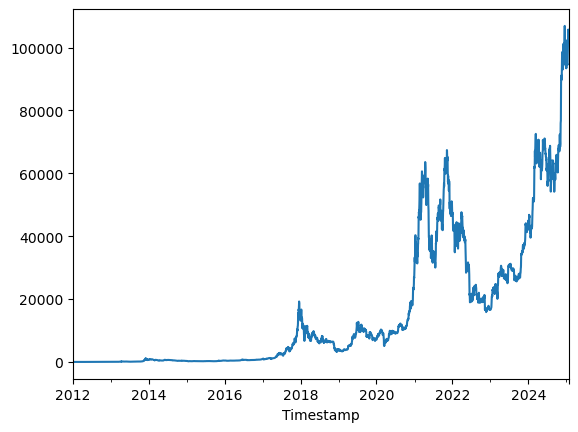

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from prophet.make_holidays import make_holidays_df


# Cargamos el csv
train = pd.read_csv('btcusd_1-min_data.csv')

print(train.shape)

# Mostramos 10 registros al azar
train.sample(10)

#miro donde hay nulls si los hay
train.isna().sum()

filas_con_nulos = train[train.isnull().any(axis=1)]
print(filas_con_nulos)

train = train.dropna()
print(train)

train['Timestamp'] = pd.to_datetime(train['Timestamp'], unit='s') 
train.set_index('Timestamp', inplace=True)
print(train)

# Calcular la media por hora y rellenar posibles nulos
data_hour = train['Close'].resample('d').mean().ffill()

# Visualizamos la serie completa
data_hour.plot()
plt.show()

In [2]:
# 1 año a considerar en el conjunto de test
n_steps = 365

# Dividimos la serie en train y test
train_size = len(data_hour) - n_steps
train, test = data_hour[:train_size], data_hour[train_size:]

In [3]:
train = pd.DataFrame({
    "ds": train.index,  # Fechas en la columna 'ds'
    "y": train.values   # Valores en la columna 'y'
})
test = pd.DataFrame({
    "ds": test.index,  # Fechas en la columna 'ds'
    "y": test.values   # Valores en la columna 'y'
})

In [4]:
# Definir festivos de EE.UU.
holidays = make_holidays_df(year_list=list(range(2012, 2025)), country="US")

# Definir los cambios de tendencia por COVID-19
changepoints = ["2020-03-01", "2020-06-01", "2021-01-01"]  # Pandemia y recuperación

# Crear modelo Prophet con los ajustes
model = Prophet(
    changepoint_prior_scale=0.1,  # Sensibilidad a cambios de tendencia
    holidays=holidays,
    changepoints=pd.to_datetime(changepoints)  # Fechas clave de COVID
)

# Agregar estacionalidades personalizadas
model.add_seasonality(name="diaria", period=1, fourier_order=5)
model.add_seasonality(name="mensual", period=30.5, fourier_order=5)

# Entrenar el modelo
model.fit(train)

# Crear predicciones
future = model.make_future_dataframe(periods=365)  # 1 año de predicción
forecast = model.predict(future)



20:12:56 - cmdstanpy - INFO - Chain [1] start processing
20:12:58 - cmdstanpy - INFO - Chain [1] done processing
20:12:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:12:58 - cmdstanpy - INFO - Chain [1] start processing
20:13:17 - cmdstanpy - INFO - Chain [1] done processing


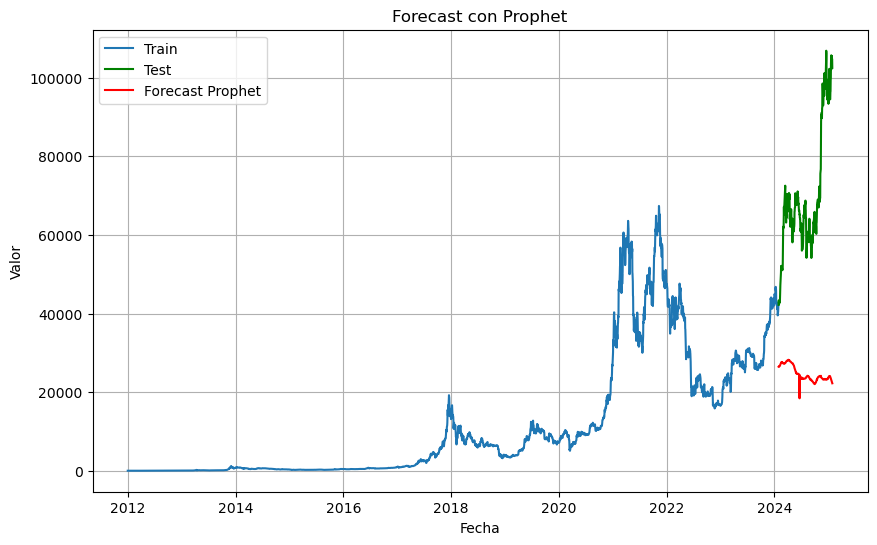

In [21]:
# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test["ds"], test["y"], label="Test", color="green")
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast Prophet', color='red')
plt.legend()
plt.title("Forecast con Prophet")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.grid()
plt.savefig("Prophet.png")
plt.show()

In [6]:
# Filtrar predicciones para las fechas de test
forecast_test = forecast[forecast["ds"].isin(test["ds"])]

# Asegurar que los índices coinciden
test_sorted = test.sort_values(by="ds").set_index("ds")
forecast_sorted = forecast_test.sort_values(by="ds").set_index("ds")

# Calcular MAE
mae = mean_absolute_error(test_sorted["y"], forecast_sorted["yhat"])
print(f'Mean Absolute Error (MAE): {mae}')

# Calcular MAPE
mape = mean_absolute_percentage_error(test_sorted["y"], forecast_sorted["yhat"])
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Absolute Error (MAE): 45427.96585672552
Mean Absolute Percentage Error (MAPE): 0.6295480817939201
